In [1]:
from Basic_Model import *
from FF_Helpers import *

In [177]:
def Feedback_Linearization(w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,30],plot = True,Noise_Variance = 1e-6,Command_perturbation = 0,ForceField = 0,ForceFieldSpan = [0,0],DisplayNonlinear = False):

    Num_iter = 60
    dt = 0.01

    st1,st2 = newton(f,df,1e-8,1000,starting_point[0],starting_point[1])
    obj1,obj2 = newton(f,df,1e-8,1000,targets[0],targets[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])

    Bruit = True
    NbreVar = 8
    
    #Define Weight Matrices
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,w2,0,0,0,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
               [0-w1,0,0,0,0,0,w1,0],[0,0,0,-w2,0,0,0,w2]])
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    Qnonlin = Q
    
    
    #Define Dynamic Matrices  
    A = np.array([[1,dt,0,0,0,0,0,0],[0,1,dt,0,0,0,0,0],[0,0,1,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,0,0,0,1,dt,0,0],[0,0,0,0,0,1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])
    B = np.array([[0,0],[0,0],[dt,0],[0,0],[0,0],[0,dt],[0,0],[0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    S = Qnonlin

    
    array_L = np.zeros((Num_iter-1,2,NbreVar))   
    array_S = np.zeros((Num_iter,NbreVar,NbreVar)) 
    array_S[-1] = Qnonlin
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    H,L = np.identity(8),array_L
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2)) 
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = np.copy(x0)
    x = np.copy(x0)
    x_changevar = np.copy(x0)
    x_internalmodel = np.copy(x0)

    reelx = np.zeros(NbreVar-2)
    reelx[0],reelx[1] = x[0],x[3]

    new_reelx = np.copy(reelx)

    reelxhat = np.zeros(NbreVar-2)
    reelxhat[0],reelxhat[1] = x[0],x[3]

    new_reelxhat = np.copy(reelxhat)
    Command_Array = np.zeros((Num_iter-1,2,2))
    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat
    v = np.zeros(2)
    for k in range(Num_iter-1):

        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else 0
        #x[2] += dt*v[0]*0.1
        #x[5]+= dt*v[1]*0.1
        #x_internalmodel[2] += dt*v[0]*0.1
        #x_internalmodel[5]+= dt*v[1]*0.1
        v = -L[k].reshape(np.flip(B.shape))@xhat + Command_perturbation
        #x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar,Noise_Variance)
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        
        Denominator = a3*(a1-a3)-a2*a2*np.cos(x[3])*np.cos(x[3])
        M = np.array([[a1+2*a2*cos(x[3]),a3+a2*cos(x[3])],[a3+a2*cos(x[3]),a3]])
        Minvdot = np.array([[-a3*a2*a2*sin(2*x[3])*x[4]/(Denominator*Denominator),
                             (a2*sin(x[3])*x[4]*Denominator+(a2*cos(x[3])+a3)*a2*a2*sin(2*x[3])*x[4])/(Denominator*Denominator)],
                            [(a2*sin(x[3])*x[4]*Denominator+(a2*cos(x[3])+a3)*a2*a2*sin(2*x[3])*x[4])/(Denominator*Denominator),
                            (-2*a2*sin(x[3])*x[4]*Denominator+(2*a2*cos(x[3])+a1)*a2*a2*sin(2*x[3])*x[4])/(Denominator*Denominator)]])
            
        Cdot = np.array([-a2*x[5]*(2*x[1]+x[4])*sin(x[3])-a2*x[4]*(2*x[2]+x[5])*sin(x[3])
                         -a2*x[4]*x[4]*(2*x[1]+x[4])*cos(x[3]),2*x[1]*x[2]*a2*sin(x[3])+x[1]*x[1]*a2*cos(x[3])*x[4]])
        K = 1/0.06
        
        COLORS = "red"
        LABEL = "Feedback Linearization"

        u = 1/K*M@(v)-1/K*M@Minvdot@M@(np.array([x[2],x[5]]))+M@(np.array([x[2],x[5]]))+C+Bdyn@np.array([x[1],x[4]])+1/K*Cdot+1/K*Bdyn@np.array([x[2],x[5]])
        Command_Array[k,0,:] = u
        Command_Array[k,1,:] = v

        new_reelx[0:2] += dt*reelx[2:4]+motor_noise[:2]
        #print("Start\n",new_reelx[2:4]-np.array([x[1],x[4]]),"\n")
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C))  
        #print(new_reelx[2:4]-np.array([(A@x+B@v)[1],(A@x+B@v)[4]]),"\n")
        new_reelx[4:6] += dt*K*(u-reelx[4:6]+F)
        new_reelxhat[0:2] += dt*reelxhat[2:4]
        new_reelxhat[2:4] += dt*(Minv@(reelxhat[4:6]-Bdyn@(reelxhat[2:4])-C))  
        new_reelxhat[4:6] += dt*K*(u-reelxhat[4:6])
        #print("HERE: ",new_reelx,new_reelxhat)
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()

        
        #x_internalmodel[0],x_internalmodel[1],x_internalmodel[3],x_internalmodel[4] = reelxhat[0],reelxhat[2],reelxhat[1],reelxhat[3]
        x_changevar[0],x_changevar[1],x_changevar[3],x_changevar[4] = new_reelx[0],new_reelx[2],new_reelx[1],new_reelx[3]
        #print("Diff :",x-x_internalmodel,"\n")
        x_changevar = x_changevar + B@v
        
        x = A@x +B@v + motor_noise
        #print(x-x_changevar)
        #print("TEST: ",x-newx,"\n")
        x_internalmodel = A@x_internalmodel+B@v

        #print(x-newx)
        #x+=motor_noise  
        if DisplayNonlinear : y[k] = (H@x_changevar+measure_noise).flatten()
        else : y[k] = (H@x+measure_noise).flatten() #For numerical errors, both lines computes same estimates up to numerical errors.
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        #print(y[k]-H@x_internalmodel)
        xhat = x_internalmodel + K@(y[k]-H@x_internalmodel)
        reelx = np.copy(new_reelx)
        reelxhat = np.copy(new_reelxhat)
        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    
    x0 = xstart
    if DisplayNonlinear : 
        x[0],x[1],x[3],x[4] = new_reelx[0],new_reelx[2],new_reelx[1],new_reelx[3]
        reelx = array_reelx.T[:,1:][:,::1]
        X = np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30
        Y = np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30
    else : 
        reelx = array_x.T[:,1:][:,::1]
        X = np.cos(reelx[0]+reelx[3])*33+np.cos(reelx[0])*30
        Y = np.sin(reelx[0]+reelx[3])*33+np.sin(reelx[0])*30

    if plot : 
        plt.grid(linestyle='--')
        plt.axis("equal")
        if Command_perturbation != 0: COLORS = "green"
        plt.plot(X,Y,color = COLORS,label = LABEL,linewidth = .8)
        plt.xlabel("X [cm]")
        plt.ylabel("Y [cm]")
        plt.scatter([starting_point[0],targets[0]],[starting_point[1],targets[1]],color = "black")
    
    J1 = x.T@Q@x
    J2 = x.T@Q@x
    for t in range(Num_iter-1):
        J1+= Command_Array[t,0,:].T@R@Command_Array[t,0,:]
        J2+= Command_Array[t,1,:].T@R@Command_Array[t,1,:]
    #print("Optimum values " + str(J1)[:8]+" and "+str(J2)[:8])
    return X,Y,J1,J2

    
def LQG(w1,w2,w3,w4,r1,r2,targets = [0,55],starting_point = [0,20],ForceField = [0,0],plot = True,ForceFieldSpan = [0,0.6],Noise_Variance = 1e-6):

    Num_iter = 600
    dt = 0.001

    obj1,obj2 = newton(f,df,1e-8,1000,targets[0],targets[1]) #Defini les targets
    st1,st2 = newton(f,df,1e-8,1000,starting_point[0],starting_point[1])

    xstart = np.array([st1,0,0,st2,0,0,obj1,0,obj2,0])
    x0 = np.array([st1,0,0,st2,0,0,obj1,obj2])
    Bruit = True
    NbreVar = 8
    
    #Define Weight Matrices
    #Q = np.array([[2*w1/5+w1,0,0,-2*w1/5,0,0,w1/5-w1,0],[0,w3,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
    #            [-2*w1/5,0,0,2*w2/5+w2,0,0,-w2/5,-w2],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
     #           [w1/5-w1,0,0,-w2/5,0,0,w1+w1/5,0],[0,0,0,-w2,0,0,0,w2]])
    R = np.array([[r1,0],[0,r2]])
    Q = np.array([[w1,0,0,0,0,0,-w1,0],[0,w2,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
             [0,0,0,w3,0,0,0,-w3],[0,0,0,0,w4,0,0,0],[0,0,0,0,0,0,0,0],
             [-w1,0,0,0,0,0,w1,0],[0,0,0,-w3,0,0,0,w3]])
    
    
    #Define Dynamic Matrices  

    A = np.array([[1,dt,0,0,0,0,0,0],[0,1+dt*(-0.5*a1+0.025*a3)/((a1-a3)*a3),dt*a1/((a1-a3)*a3),0,dt*(-0.025*a1+0.5*a3)/((a1-a3)*a3),dt/(a3-a1),0,0],
     [0,0,1-dt/tau,0,0,0,0,0],[0,0,0,1,dt,0,0,0],[0,dt*0.475/(a1-a3),-dt/(a1-a3),0,1-dt*0.475/(a1-a3),dt/(a1-a3),0,0],
     [0,0,0,0,0,1-dt/tau,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]])

    B = np.transpose([[0,0,dt/tau,0,0,0,0,0],[0,0,0,0,0,dt/tau,0,0]])
    
    
    #Reverse Iterations
    #print(Qnonlin.astype(int))
    S = Q

    
    array_L = np.zeros((Num_iter-1,2,NbreVar))   
    array_S = np.zeros((Num_iter,NbreVar,NbreVar)) 
    array_S[-1] = Q
    for k in range(Num_iter-1):
        L = np.linalg.inv(R+B.T@S@B)@B.T@S@A
        array_L[Num_iter-2-k] = L
        S = A.T@S@(A-B@L)
        array_S[Num_iter-2-k] = S
        
    #print(array_L[0])
    #Feedback
    H,L= np.identity(8),array_L
        
    array_x = np.zeros((Num_iter,NbreVar))
    array_xhat = np.zeros((Num_iter,NbreVar))
    array_reelx = np.zeros((Num_iter,NbreVar-2)) 
    y = np.zeros((Num_iter,NbreVar))

    array_x[0] = x0.flatten()
    array_xhat[0] = x0.flatten()
    xhat = x0
    x = x0

    reelx = np.zeros(NbreVar-2)
    reelx[0] = x[0]
    reelx[1] = x[3]
    new_reelx = reelx

    sigma = np.identity(NbreVar)*10**-6 #Espérance de (erreur erreur^) avec erreur = x - xhat

    Command_Array = []
    for k in range(Num_iter-1):
        F = ForceField if ((k*dt > ForceFieldSpan[0]) and (k*dt < ForceFieldSpan[1])) else 0
        

        x[0],x[1],x[3],x[4] = reelx[0],reelx[2],reelx[1],reelx[3]        
        Omega_sens,motor_noise,Omega_measure,measure_noise = Bruitage(Bruit,NbreVar,Noise_Variance)
        y[k] = (H@x+measure_noise).flatten()
        K = A@sigma@H.T@np.linalg.inv(H@sigma@H.T+Omega_measure)
        sigma = Omega_sens + (A - K@H)@sigma@A.T
        xhat = A@xhat - B@L[k].reshape(np.flip(B.shape))@xhat + K@(y[k]-H@xhat)
        x = A@x-B@L[k].reshape(np.flip(B.shape))@xhat+motor_noise
        u = -L[k].reshape(np.flip(B.shape))@xhat
        Command_Array.append(u)
            
        C = np.array([-reelx[3]*(2*reelx[2]+reelx[3])*a2*np.sin(reelx[1]),reelx[2]*reelx[2]*a2*np.sin(reelx[1])])
        Denominator = a3*(a1-a3)-a2*a2*np.cos(reelx[1])*np.cos(reelx[1])
        Minv = np.array([[a3/Denominator,(-a2*np.cos(reelx[1])-a3)/Denominator],[(-a2*np.cos(reelx[1])-a3)/Denominator,(2*a2*np.cos(reelx[1])+a1)/Denominator]])
        new_reelx[0:2] += dt*reelx[2:4]+motor_noise[:2]
        new_reelx[2:4] += dt*(Minv@(reelx[4:6]-Bdyn@(reelx[2:4])-C))  
        K = 1/0.06
        new_reelx[4:6] += dt*K*(u-reelx[4:6]+F)
            
        array_xhat[k+1] = xhat.flatten()
        array_x[k+1]= x.flatten()
        array_reelx[k+1] = new_reelx.flatten()
        reelx = new_reelx 
        #print(array_x[k-1,2],((array_x[k]-array_x[k-1])/dt)[1])   

#Plot
    x0 = xstart
    reelx = array_reelx.T[:,1:][:,::1]

    J = x.T@Q@x
    for t in range(Num_iter-1):
        J+= np.array(Command_Array)[t,:]@R@np.array(Command_Array)[t,:]
    print("LQG Optimum " + str(J))
    if plot:
        plt.plot(np.cos(reelx[0]+reelx[1])*33+np.cos(reelx[0])*30,np.sin(reelx[0]+reelx[1])*33+np.sin(reelx[0])*30,color = "green",label = "LQG",linewidth = .8)


# Simple Movement with no perturbation and Nonlinear plant

In [178]:
def plotSimpleMovements(Pert,FSpan,Noise):
    fig,ax = plt.subplots()
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    LQG(1e6,1e6,1e6,1e6,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise)
    X,Y,_,_ = Feedback_Linearization(1e6,1e6,1e5,1e5,1e-5,1e-5,targets = [0,55],starting_point = [0,20],ForceField = Pert,ForceFieldSpan= FSpan,plot = True,Noise_Variance=Noise,DisplayNonlinear=True)
    #plt.legend()
    ax.text(
        10,
        50,
        "LQG",
        color="green",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    ax.text(
        X[50]-15,
        50,
        "Feedback\n Linearization",
        color="red",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
    if FSpan[0] != FSpan[1]:
        ax.text(
        -20,
        Y[20]+3,
        "Perturbation \n onset",
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize = 8

        )
        plt.plot(np.linspace(-20,30,1000),np.ones(1000)*Y[20],color = "black",alpha = .8)
        plt.xlim(-20,30)
        ax.text(
        -20,
        Y[40]+3,
        "Perturbation \n offset",
        color="black",
        horizontalalignment="left",
        verticalalignment="center",
        fontsize = 8

        )
        plt.plot(np.linspace(-20,30,1000),np.ones(1000)*Y[40],color = "black",alpha = .8)
        plt.xlim(-20,30)
    plt.show()

    fig,ax = plt.subplots()
    plt.grid(alpha = .5)
    plt.xlabel("Time [sec]")
    plt.ylabel("Velocity of the Movement [cm/sec]")
    plt.plot(np.arange(0,0.58,0.01),(Y[1:]-Y[0:len(X)-1])/0.01)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    plt.show()

LQG Optimum 63974497.33484033


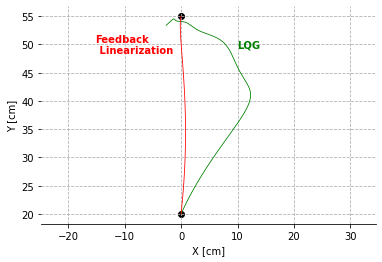

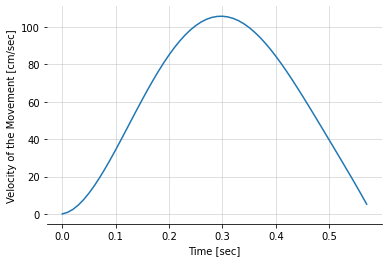

LQG Optimum 141317477.285061


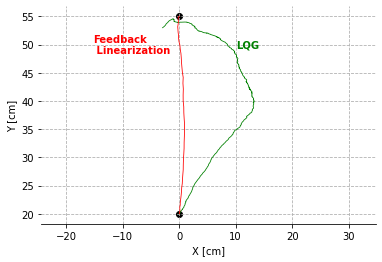

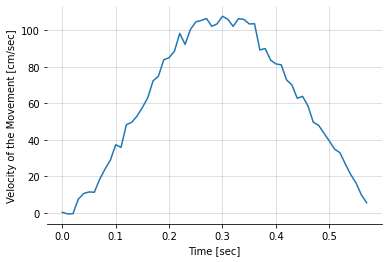

In [180]:
plotSimpleMovements([0.5,0.5],[0.2,0.2],1e-12)
plotSimpleMovements([0.5,0.5],[0.2,0.2],1e-6)



LQG Optimum 83166122.72965913


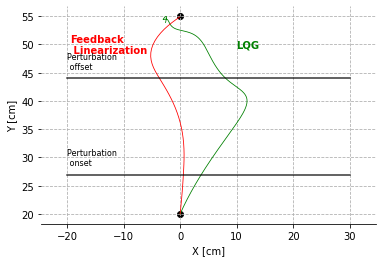

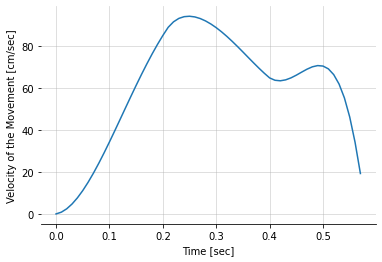

LQG Optimum 40132207.89623383


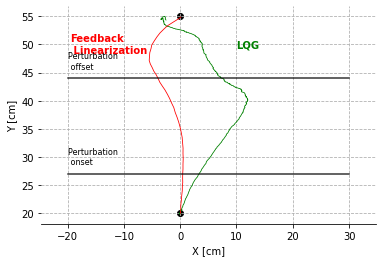

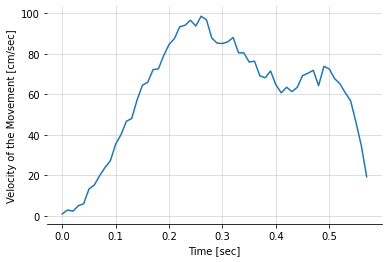

In [183]:
plotSimpleMovements([1,1],[0.2,0.4],1e-12)
plotSimpleMovements([1,1],[0.2,0.4],1e-6)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


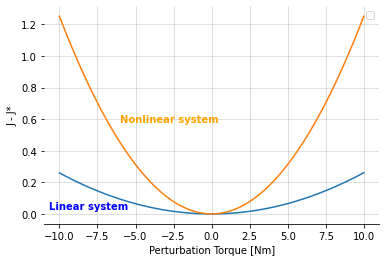

In [110]:
fig,ax = plt.subplots()
X,Y,J1Ref,J2Ref = Feedback_Linearization(1e7,1e7,1e5,1e5,1e-5,1e-5,targets = [0,55],starting_point = [0,20],plot = False,Noise_Variance=1e-16,Command_perturbation=0)
J1Array = []
J2Array = []
MyPert = np.linspace(-10,10,100)
for Command_perturbation in MyPert:
    X,Y,J1,J2 = Feedback_Linearization(1e7,1e7,1e5,1e5,1e-5,1e-5,targets = [0,55],starting_point = [0,20],plot = False,Noise_Variance=1e-16,Command_perturbation=Command_perturbation)
    J1Array.append(J1-J1Ref)
    J2Array.append(J2-J2Ref)
plt.grid(alpha = .5)
plt.xlabel("Perturbation Torque [Nm]")
plt.ylabel("J - J*")
plt.plot(MyPert,J1Array)
plt.plot(MyPert,J2Array)
ax.text(
        -6,
        0.6,
        "Nonlinear system",
        color="orange",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
ax.text(
        -10.7,
        0.05,
        "Linear system",
        color="blue",
        fontweight="bold",
        horizontalalignment="left",
        verticalalignment="center",
    )
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend()